In [1]:
#prepare problem
import pandas as pd
import numpy as np
import seaborn as sns
import time
import random
import plotly.express as px
import matplotlib.pyplot as plt
from iso639 import languages
import user_agents
from ip2geotools.databases.noncommercial import DbIpCity as ip2geo
import requests
import json
from geopy.distance import great_circle
from geopy.geocoders import Nominatim
from datasist.structdata import detect_outliers
from sklearn.impute import SimpleImputer
from sklearn.impute import KNNImputer
from sklearn.preprocessing import OneHotEncoder
import category_encoders as ce
from datetime import datetime
from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler 
from imblearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

%matplotlib inline


In [2]:
df=pd.read_csv('corona.csv')
df.head()

,id,case_in_country,reporting date,Unnamed: 3,summary,location,country,gender,age,symptom_onset,...,recovered,symptom,source,link,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
0,1,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,"Shenzhen, Guangdong",China,male,66.0,01/03/20,...,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...,NaN,NaN,NaN,NaN,NaN,NaN
1,2,NaN,1/20/2020,NaN,First confirmed imported COVID-19 pneumonia pa...,Shanghai,China,female,56.0,1/15/2020,...,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...,NaN,NaN,NaN,NaN,NaN,NaN
2,3,NaN,1/21/2020,NaN,First confirmed imported cases in Zhejiang: pa...,Zhejiang,China,male,46.0,01/04/20,...,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...,NaN,NaN,NaN,NaN,NaN,NaN
3,4,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,female,60.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN
4,5,NaN,1/21/2020,NaN,new confirmed imported COVID-19 pneumonia in T...,Tianjin,China,male,58.0,NaN,...,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?,NaN,NaN,NaN,NaN,NaN,NaN


In [3]:
""'''''
#def dataset_shape():
    print("head : ",df.head() )
    print("shape : ",df.shape )
    print("describe : ",df.describe() )
    print("describe categories : ",df.describe(include='O') )
    print("types : ",df.dtypes )
    print("null columns : ",df.isnull().sum() )
    print("info : ",df.info() )
    
''''''    

(1085, 27)

In [3]:
#summarize data
df.shape
df.dtypes

id                         int64
case_in_country          float64
reporting date            object
Unnamed: 3               float64
summary                   object
location                  object
country                   object
gender                    object
age                      float64
symptom_onset             object
If_onset_approximated    float64
hosp_visit_date           object
exposure_start            object
exposure_end              object
visiting Wuhan             int64
from Wuhan               float64
death                     object
recovered                 object
symptom                   object
source                    object
link                      object
Unnamed: 21              float64
Unnamed: 22              float64
Unnamed: 23              float64
Unnamed: 24              float64
Unnamed: 25              float64
Unnamed: 26              float64
dtype: object

In [4]:
df.describe()

,id,case_in_country,Unnamed: 3,age,If_onset_approximated,visiting Wuhan,from Wuhan,Unnamed: 21,Unnamed: 22,Unnamed: 23,Unnamed: 24,Unnamed: 25,Unnamed: 26
count,1085.000000,888.000000,0.0,843.000000,560.000000,1085.000000,1081.000000,0.0,0.0,0.0,0.0,0.0,0.0
mean,543.000000,48.841216,NaN,49.483689,0.042857,0.176959,0.144311,NaN,NaN,NaN,NaN,NaN,NaN
std,313.356825,78.853528,NaN,18.255334,0.202716,0.381810,0.351567,NaN,NaN,NaN,NaN,NaN,NaN
min,1.000000,1.000000,NaN,0.250000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
25%,272.000000,11.000000,NaN,35.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
50%,543.000000,28.000000,NaN,51.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
75%,814.000000,67.250000,NaN,64.000000,0.000000,0.000000,0.000000,NaN,NaN,NaN,NaN,NaN,NaN
max,1085.000000,1443.000000,NaN,96.000000,1.000000,1.000000,1.000000,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
df.describe(include="O")

,reporting date,summary,location,country,gender,symptom_onset,hosp_visit_date,exposure_start,exposure_end,death,recovered,symptom,source,link
count,1084,1080,1085,1085,902,563,507,128,341,1085,1085,270,1085,1085
unique,43,967,156,38,2,70,60,39,52,14,32,108,85,490
top,2/27/2020,new confirmed COVID-19 patient in South Korea:,South Korea,China,male,1/23/2020,1/23/2020,1/26/2020,1/22/2020,0,0,fever,Ministry of Health,https://www.mhlw.go.jp/stf/houdou/houdou_list_...
freq,91,22,112,197,520,27,34,14,34,1022,926,73,179,88


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 27 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     1085 non-null   int64  
 1   case_in_country        888 non-null    float64
 2   reporting date         1084 non-null   object 
 3   Unnamed: 3             0 non-null      float64
 4   summary                1080 non-null   object 
 5   location               1085 non-null   object 
 6   country                1085 non-null   object 
 7   gender                 902 non-null    object 
 8   age                    843 non-null    float64
 9   symptom_onset          563 non-null    object 
 10  If_onset_approximated  560 non-null    float64
 11  hosp_visit_date        507 non-null    object 
 12  exposure_start         128 non-null    object 
 13  exposure_end           341 non-null    object 
 14  visiting Wuhan         1085 non-null   int64  
 15  from

In [7]:
df.isnull().sum()


id                          0
case_in_country           197
reporting date              1
Unnamed: 3               1085
summary                     5
location                    0
country                     0
gender                    183
age                       242
symptom_onset             522
If_onset_approximated     525
hosp_visit_date           578
exposure_start            957
exposure_end              744
visiting Wuhan              0
from Wuhan                  4
death                       0
recovered                   0
symptom                   815
source                      0
link                        0
Unnamed: 21              1085
Unnamed: 22              1085
Unnamed: 23              1085
Unnamed: 24              1085
Unnamed: 25              1085
Unnamed: 26              1085
dtype: int64

In [8]:
df.drop(['id','case_in_country','summary','Unnamed: 3','Unnamed: 21', 'Unnamed: 22',
      'Unnamed: 23', 'Unnamed: 24', 'Unnamed: 25', 'Unnamed: 26','If_onset_approximated','symptom_onset'],axis=1,inplace=True)

In [9]:
df.columns
df.columns=df.columns.str.strip().str.lower().str.replace(' ','_')
df.columns

Index(['reporting_date', 'location', 'country', 'gender', 'age',
       'hosp_visit_date', 'exposure_start', 'exposure_end', 'visiting_wuhan',
       'from_wuhan', 'death', 'recovered', 'symptom', 'source', 'link'],
      dtype='object')

In [10]:
df.isnull().sum()

reporting_date       1
location             0
country              0
gender             183
age                242
hosp_visit_date    578
exposure_start     957
exposure_end       744
visiting_wuhan       0
from_wuhan           4
death                0
recovered            0
symptom            815
source               0
link                 0
dtype: int64

In [11]:
df.shape
df.describe()
df.describe(include='O')
df.dtypes
df.info()
df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1085 entries, 0 to 1084
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   reporting_date   1084 non-null   object 
 1   location         1085 non-null   object 
 2   country          1085 non-null   object 
 3   gender           902 non-null    object 
 4   age              843 non-null    float64
 5   hosp_visit_date  507 non-null    object 
 6   exposure_start   128 non-null    object 
 7   exposure_end     341 non-null    object 
 8   visiting_wuhan   1085 non-null   int64  
 9   from_wuhan       1081 non-null   float64
 10  death            1085 non-null   object 
 11  recovered        1085 non-null   object 
 12  symptom          270 non-null    object 
 13  source           1085 non-null   object 
 14  link             1085 non-null   object 
dtypes: float64(2), int64(1), object(12)
memory usage: 127.3+ KB


,reporting_date,location,country,gender,age,hosp_visit_date,exposure_start,exposure_end,visiting_wuhan,from_wuhan,death,recovered,symptom,source,link
0,1/20/2020,"Shenzhen, Guangdong",China,male,66.0,01/11/20,12/29/2019,01/04/20,1,0.0,0,0,NaN,Shenzhen Municipal Health Commission,http://wjw.sz.gov.cn/wzx/202001/t20200120_1898...
1,1/20/2020,Shanghai,China,female,56.0,1/15/2020,NaN,01/12/20,0,1.0,0,0,NaN,Official Weibo of Shanghai Municipal Health Co...,https://www.weibo.com/2372649470/IqogQhgfa?fro...
2,1/21/2020,Zhejiang,China,male,46.0,1/17/2020,NaN,01/03/20,0,1.0,0,0,NaN,Health Commission of Zhejiang Province,http://www.zjwjw.gov.cn/art/2020/1/21/art_1202...
3,1/21/2020,Tianjin,China,female,60.0,1/19/2020,NaN,NaN,1,0.0,0,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?
4,1/21/2020,Tianjin,China,male,58.0,1/14/2020,NaN,NaN,0,0.0,0,0,NaN,人民日报官方微博,https://m.weibo.cn/status/4463235401268457?
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2/25/2020,Innsbruck,Austria,NaN,24.0,NaN,NaN,NaN,0,0.0,0,0,NaN,Jakarta Post,https://www.thejakartapost.com/news/2020/02/25...
1081,2/24/2020,Afghanistan,Afghanistan,NaN,35.0,NaN,NaN,NaN,0,0.0,0,0,NaN,Fox News,https://www.foxnews.com/health/afghanistan-fir...
1082,2/26/2020,Algeria,Algeria,male,NaN,NaN,NaN,2/17/2020,0,0.0,0,0,NaN,South China Morning Post,https://www.scmp.com/news/china/society/articl...
1083,2/25/2020,Croatia,Croatia,male,NaN,NaN,2/19/2020,2/21/2020,0,0.0,0,0,NaN,Reuters,https://www.reuters.com/article/us-croatia-cor...


In [13]:
#univariate analysis
lst=list(df.columns)
#for i in lst
for i in range(len(lst)) :
    fig=px.histogram(df,x=lst[i],color_discrete_sequence=['blue'],title=f'for feature {lst[i]}',text_auto=True)
    fig.show()

In [114]:
#bivariate analysis
for i in range(len(lst)) :
    for j in range(i+1,len(lst)) :
        fig=px.scatter(df,x=lst[i],y=lst[j],color_discrete_sequence=['blue'],title=f'for features {lst[i]} vs {lst[j]}')
        fig.show()

IndexError: list index out of range

In [17]:
#prepare data 
#feature extraction
#domain knowledge feature
df
#data and time feature
df
lst=['reporting_date','hosp_visit_date','exposure_start','exposure_end']
for i in lst:
    df[i]=pd.to_datetime(df[i],errors='coerce')
    df[f'{i}_year']=df[i].dt.year.astype(int)
    df[f'{i}_month']=df[i].dt.month.astype(int)
    df[f'{i}_day']=df[i].dt.day.astype(int)
    
def get_season(x):
    if x in [12,1,2]:
        return 'winter'
    elif x in [3,4,5]:
        return 'spring'
    elif x in [6,7,8]:
        return 'summer'
    elif x in [9,10,11]:
        return 'autumn'
    else :
        return 'NaN'

df['exposure_season']=df['exposure_start_month'].apply(get_season)
#df['exposure_start_month']=df['exposure_start_month'].apply(lambda x : 'winter' if x in [12,1,2] elif x in [3,4,5] 'spring'
#elif x in [6,7,8] 'summer' elif x in [9,10,11] 'autums' else 'NaN')

df['exposure_period']=(df['exposure_end']-df['exposure_start']).abs()
df
#string operation 
df.columns=df.columns.str.strip().str.lower().str.replace(' ','_')
df.columns
df
#web data
#geospatial features

,reporting_date,location,country,gender,age,hosp_visit_date,exposure_start,exposure_end,death,recovered,...,hosp_visit_date_month,hosp_visit_date_day,exposure_start_year,exposure_start_month,exposure_start_day,exposure_end_year,exposure_end_month,exposure_end_day,exposure_season,exposure_period
0,2020-01-20,"Shenzhen, Guangdong",China,male,66.000000,2020-01-11,2019-12-29,2020-01-04,0,0,...,1,11,2019,12,29,2020,1,4,winter,6 days
1,2020-01-20,Shanghai,China,female,56.000000,2020-01-15,2020-01-26,2020-01-12,0,0,...,1,15,2020,1,26,2020,1,12,winter,14 days
2,2020-01-21,Zhejiang,China,male,46.000000,2020-01-17,2020-01-26,2020-01-03,0,0,...,1,17,2020,1,26,2020,1,3,winter,23 days
3,2020-01-21,Tianjin,China,female,60.000000,2020-01-19,2020-01-26,2020-01-22,0,0,...,1,19,2020,1,26,2020,1,22,winter,4 days
4,2020-01-21,Tianjin,China,male,58.000000,2020-01-14,2020-01-26,2020-01-22,0,0,...,1,14,2020,1,26,2020,1,22,winter,4 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2020-02-25,Innsbruck,Austria,male,24.000000,2020-01-23,2020-01-26,2020-01-22,0,0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1081,2020-02-24,Afghanistan,Afghanistan,male,35.000000,2020-01-23,2020-01-26,2020-01-22,0,0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1082,2020-02-26,Algeria,Algeria,male,49.483689,2020-01-23,2020-01-26,2020-02-17,0,0,...,1,23,2020,1,26,2020,2,17,winter,22 days
1083,2020-02-25,Croatia,Croatia,male,49.483689,2020-01-23,2020-02-19,2020-02-21,0,0,...,1,23,2020,2,19,2020,2,21,winter,2 days


In [14]:
#feature transformation
#cleansing 
#working with missing data
df.drop(['visiting_wuhan','from_wuhan'],axis=1,inplace=True)
df.shape
df.dtypes

reporting_date      object
location            object
country             object
gender              object
age                float64
hosp_visit_date     object
exposure_start      object
exposure_end        object
death               object
recovered           object
symptom             object
source              object
link                object
dtype: object

In [15]:
df.isnull().sum()
df.columns

Index(['reporting_date', 'location', 'country', 'gender', 'age',
       'hosp_visit_date', 'exposure_start', 'exposure_end', 'death',
       'recovered', 'symptom', 'source', 'link'],
      dtype='object')

In [53]:
for i in df.columns:
    if df[i].isnull().sum() > 0 :
        if df[i].dtypes == 'float64' or df[i].dtypes == 'int32' :
            df[i]=df[i].fillna(df[i].mean())
        else :
            df[i]=df[i].fillna(df[i].mode()[0])           
df.isnull().sum()            

reporting_date           0
location                 0
country                  0
gender                   0
age                      0
hosp_visit_date          0
exposure_start           0
exposure_end             0
death                    0
recovered                0
symptom                  0
source                   0
reporting_date_year      0
reporting_date_month     0
reporting_date_day       0
hosp_visit_date_year     0
hosp_visit_date_month    0
hosp_visit_date_day      0
exposure_start_year      0
exposure_start_month     0
exposure_start_day       0
exposure_end_year        0
exposure_end_month       0
exposure_end_day         0
exposure_season          0
exposure_period          0
dtype: int64

In [18]:
#df.dtypes
lst=['death','recovered']
for i in lst :
    df[i]=pd.to_numeric(df[i],errors='coerce')
df.dtypes 

reporting_date            datetime64[ns]
location                          object
country                           object
gender                            object
age                              float64
hosp_visit_date           datetime64[ns]
exposure_start            datetime64[ns]
exposure_end              datetime64[ns]
death                            float64
recovered                        float64
symptom                           object
source                            object
link                              object
reporting_date_year                int32
reporting_date_month               int32
reporting_date_day                 int32
hosp_visit_date_year               int32
hosp_visit_date_month              int32
hosp_visit_date_day                int32
exposure_start_year                int32
exposure_start_month               int32
exposure_start_day                 int32
exposure_end_year                  int32
exposure_end_month                 int32
exposure_end_day

In [19]:
lst=[0,1]

def get_x(x):
    if x not in lst :
        return 0
    else :
        return x
df['death']=df['death'].apply(get_x)       
df['recovered']=df['recovered'].apply(get_x)  
df['age']=df['age'].astype(int)
df.dtypes

reporting_date            datetime64[ns]
location                          object
country                           object
gender                            object
age                                int32
hosp_visit_date           datetime64[ns]
exposure_start            datetime64[ns]
exposure_end              datetime64[ns]
death                            float64
recovered                        float64
symptom                           object
source                            object
link                              object
reporting_date_year                int32
reporting_date_month               int32
reporting_date_day                 int32
hosp_visit_date_year               int32
hosp_visit_date_month              int32
hosp_visit_date_day                int32
exposure_start_year                int32
exposure_start_month               int32
exposure_start_day                 int32
exposure_end_year                  int32
exposure_end_month                 int32
exposure_end_day

detect outliers
---------------------------------------------


,reporting_date,location,country,gender,age,hosp_visit_date,exposure_start,exposure_end,death,recovered,...,hosp_visit_date_month,hosp_visit_date_day,exposure_start_year,exposure_start_month,exposure_start_day,exposure_end_year,exposure_end_month,exposure_end_day,exposure_season,exposure_period
0,2020-01-20,"Shenzhen, Guangdong",China,male,66,2020-01-11,2019-12-29,2020-01-04,0.0,0.0,...,1,11,2019,12,29,2020,1,4,winter,6 days
1,2020-01-20,Shanghai,China,female,56,2020-01-15,2020-01-26,2020-01-12,0.0,0.0,...,1,15,2020,1,26,2020,1,12,winter,14 days
2,2020-01-21,Zhejiang,China,male,46,2020-01-17,2020-01-26,2020-01-03,0.0,0.0,...,1,17,2020,1,26,2020,1,3,winter,23 days
3,2020-01-21,Tianjin,China,female,60,2020-01-19,2020-01-26,2020-01-22,0.0,0.0,...,1,19,2020,1,26,2020,1,22,winter,4 days
4,2020-01-21,Tianjin,China,male,58,2020-01-14,2020-01-26,2020-01-22,0.0,0.0,...,1,14,2020,1,26,2020,1,22,winter,4 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1080,2020-02-25,Innsbruck,Austria,male,24,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1081,2020-02-24,Afghanistan,Afghanistan,male,35,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1082,2020-02-26,Algeria,Algeria,male,49,2020-01-23,2020-01-26,2020-02-17,0.0,0.0,...,1,23,2020,1,26,2020,2,17,winter,22 days
1083,2020-02-25,Croatia,Croatia,male,49,2020-01-23,2020-02-19,2020-02-21,0.0,0.0,...,1,23,2020,2,19,2020,2,21,winter,2 days


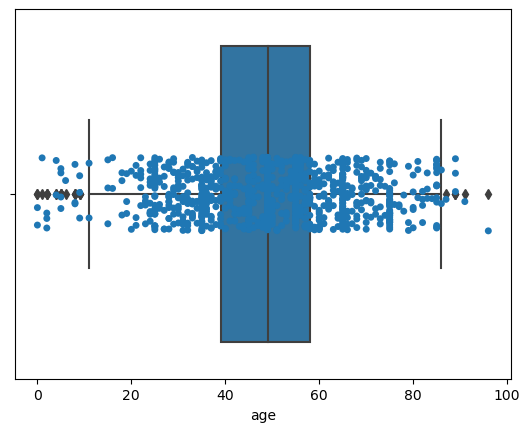

In [20]:
#detect and handle outliers
#detect
lst=[]
for i in df.columns:
    if df[i].dtypes == 'int32' or df[i].dtypes == 'float64' :
        lst.append(i)
lst        

print("detect outliers")
print("---------------------------------------------")
sns.boxplot(data=df,x='age')
sns.stripplot(data=df,x='age')
    
lst
df

In [25]:
#remove outliers
lst
outliers_indices=detect_outliers(df,0,['age'])

df.drop(outliers_indices,inplace=True)



In [24]:
#replace outliers with median
for col in lst :
    outliers_indices=detect_outliers(df,0,[col])
    median=int(df[col].mean())
    df[col].iloc[outliers_indices]=median


C:\Users\C.LAB\AppData\Local\Temp\ipykernel_14288\4156731818.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



<AxesSubplot:xlabel='age'>

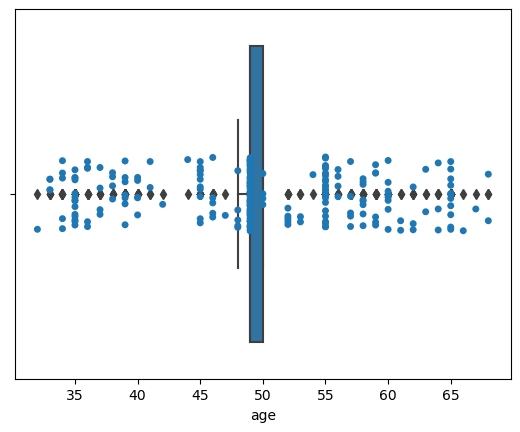

In [26]:
sns.boxplot(data=df,x='age')
sns.stripplot(data=df,x='age')


In [27]:
#work with categorical data
lst=[]
for i in df.columns:
    if df[i].dtypes == 'object':
        lst.append(i)
lst
df

,reporting_date,location,country,gender,age,hosp_visit_date,exposure_start,exposure_end,death,recovered,...,hosp_visit_date_month,hosp_visit_date_day,exposure_start_year,exposure_start_month,exposure_start_day,exposure_end_year,exposure_end_month,exposure_end_day,exposure_season,exposure_period
3,2020-01-21,Tianjin,China,female,60,2020-01-19,2020-01-26,2020-01-22,0.0,0.0,...,1,19,2020,1,26,2020,1,22,winter,4 days
5,2020-01-21,Chongqing,China,female,44,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
6,2020-01-21,Sichuan,China,male,34,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
17,2020-01-22,Macau,China,female,52,2020-01-22,2020-01-26,2020-01-22,0.0,0.0,...,1,22,2020,1,26,2020,1,22,winter,4 days
28,2020-01-22,Guangxi,China,male,46,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2020-02-25,Bahrain,Bahrain,male,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1076,2020-02-25,Bahrain,Bahrain,male,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1077,2020-02-25,Bahrain,Bahrain,female,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days
1078,2020-02-25,Bahrain,Bahrain,female,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,winter,4 days


In [28]:
#work with ordinal data
dict_season={
    
    'winter':1,'spring':2,'summer':3,'autumn':4
}
df['exposure_season']=df['exposure_season'].map(dict_season)
lst
df[lst]
df

,reporting_date,location,country,gender,age,hosp_visit_date,exposure_start,exposure_end,death,recovered,...,hosp_visit_date_month,hosp_visit_date_day,exposure_start_year,exposure_start_month,exposure_start_day,exposure_end_year,exposure_end_month,exposure_end_day,exposure_season,exposure_period
3,2020-01-21,Tianjin,China,female,60,2020-01-19,2020-01-26,2020-01-22,0.0,0.0,...,1,19,2020,1,26,2020,1,22,1,4 days
5,2020-01-21,Chongqing,China,female,44,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days
6,2020-01-21,Sichuan,China,male,34,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days
17,2020-01-22,Macau,China,female,52,2020-01-22,2020-01-26,2020-01-22,0.0,0.0,...,1,22,2020,1,26,2020,1,22,1,4 days
28,2020-01-22,Guangxi,China,male,46,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1075,2020-02-25,Bahrain,Bahrain,male,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days
1076,2020-02-25,Bahrain,Bahrain,male,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days
1077,2020-02-25,Bahrain,Bahrain,female,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days
1078,2020-02-25,Bahrain,Bahrain,female,49,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,...,1,23,2020,1,26,2020,1,22,1,4 days


In [44]:
#work with nominal
#one hot encoding
df_new=df
#df_new.drop(['link'],axis=1,inplace=True)
#lst.remove('link')
#lst.remove('exposure_season')
df_new['symptom'].value_counts()
df_new['gender'].value_counts()

male      262
female    103
Name: gender, dtype: int64

In [45]:
#data cleaning
df['symptom'].value_counts()
#df['symptom']=df['symptom'].apply(lambda x : df['symptom'].mode()[0] if x ! = 'fever' and x != 'fever, cough' else x  )
def get_x (x) : 
    if x != 'fever' and x != 'fever, cough' :
        return df['symptom'].mode()[0]
    else :
        return x
df['symptom']=df['symptom'].apply(get_x)

df_new['symptom'].value_counts()

fever           360
fever, cough      5
Name: symptom, dtype: int64

In [40]:
lst

['location', 'country', 'gender', 'symptom', 'source']

In [46]:
lst_small=['gender', 'symptom']
ohe = OneHotEncoder(sparse=False )
ohe.fit_transform(df_new[lst_small])
df_ohe = pd.DataFrame(ohe.fit_transform(df_new[lst_small]) , columns=ohe.get_feature_names_out())
df_new = pd.concat([df_new , df_ohe ] , axis = 1)
df_new.drop(lst_small , axis = 1 , inplace = True )
df_new


,reporting_date,location,country,age,hosp_visit_date,exposure_start,exposure_end,death,recovered,source,...,exposure_start_day,exposure_end_year,exposure_end_month,exposure_end_day,exposure_season,exposure_period,gender_female,gender_male,symptom_fever,"symptom_fever, cough"
3,2020-01-21,Tianjin,China,60.0,2020-01-19,2020-01-26,2020-01-22,0.0,0.0,人民日报官方微博,...,26.0,2020.0,1.0,22.0,1.0,4 days,1.0,0.0,1.0,0.0
5,2020-01-21,Chongqing,China,44.0,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,Chongqing Municipal Health Commission,...,26.0,2020.0,1.0,22.0,1.0,4 days,0.0,1.0,1.0,0.0
6,2020-01-21,Sichuan,China,34.0,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,央视新闻,...,26.0,2020.0,1.0,22.0,1.0,4 days,1.0,0.0,1.0,0.0
17,2020-01-22,Macau,China,52.0,2020-01-22,2020-01-26,2020-01-22,0.0,0.0,央视新闻,...,26.0,2020.0,1.0,22.0,1.0,4 days,0.0,1.0,1.0,0.0
28,2020-01-22,Guangxi,China,46.0,2020-01-23,2020-01-26,2020-01-22,0.0,0.0,央视新闻,...,26.0,2020.0,1.0,22.0,1.0,4 days,1.0,0.0,1.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
358,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,1.0,0.0,1.0,0.0
360,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,0.0,1.0,1.0,0.0
362,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,1.0,0.0,1.0,0.0
363,NaT,NaN,NaN,NaN,NaT,NaT,NaT,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaT,1.0,0.0,1.0,0.0


In [48]:
#bianry encoding
df_new.columns
df.columns=df.columns.str.strip().str.lower()
df.columns=df.columns.str.replace(' ','_')
df.columns
for i in lst_small:
    lst.remove(i)
lst_big=lst    
for i in lst_big :
    ce_bin=ce.BinaryEncoder()
    y=ce_bin.fit_transform(df_new[[i]])
    df_new=pd.concat([df_new,y],axis=1)
    df_new.drop([i],axis=1,inplace=True)
#check of there is categorical data left
lst_1=[]
for i in df_new.columns:
    if df_new[i].dtype == 'object':
        lst_1.append(i)
lst_1   


[]

In [55]:
#df_new.drop(['reporting_date','hosp_visit_date','exposure_start','exposure_end'],axis=1,inplace=True)
for i in df_new.columns:
    if df_new[i].isnull().sum() > 0 :
        if df_new[i].dtypes == 'float64' or df_new[i].dtypes == 'int32' :
            df_new[i]=df_new[i].fillna(df_new[i].mean())
        else :
            df_new[i]=df_new[i].fillna(df_new[i].mode()[0])           
for i in df_new.columns:
    if df_new[i].dtype=='float64':
        df_new[i]=df_new[i].astype(int)
for i in df.columns :
    print(f"for feature {i} : \n")
    print(df[i].value_counts())
       

for feature reporting_date : 

2020-02-27    56
2020-02-20    53
2020-02-25    26
2020-02-21    19
2020-02-26    16
2020-02-28    15
2020-01-31    15
2020-02-24    14
2020-02-19    13
2020-01-26    12
2020-02-23    12
2020-01-22    11
2020-01-30    10
2020-02-06     9
2020-01-25     8
2020-02-08     8
2020-01-24     7
2020-01-28     7
2020-02-04     6
2020-02-05     6
2020-01-21     5
2020-02-15     5
2020-01-27     5
2020-02-22     4
2020-02-18     4
2020-02-16     4
2020-02-14     3
2020-02-13     2
2020-02-07     2
2020-02-17     2
2020-02-11     2
2020-01-29     1
2020-01-23     1
2020-02-10     1
2020-02-09     1
Name: reporting_date, dtype: int64
for feature location : 

South Korea               65
Thailand                  25
North Rhine-Westphalia    18
Bahrain                   17
UAE                       15
                          ..
Chongqing                  1
Thanh Hoa                  1
NSW                        1
Tubingen                   1
Afghanistan             

In [67]:
#spilitting and balancing data
#spiliting
x=df_new.drop(['symptom_fever, cough'],axis=1)
y=df_new['symptom_fever, cough']
print(y.value_counts())
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2,shuffle=True)
#sampling
over=RandomOverSampler()
x_train,y_train=over.fit_resample(x_train,y_train)
y_train.value_counts()    



0    645
1      5
Name: symptom_fever, cough, dtype: int64


0    516
1    516
Name: symptom_fever, cough, dtype: int64

In [64]:
df_new.dtypes
df_new['exposure_period']=df['exposure_period']
df_new.dtypes

age                        int32
death                      int32
recovered                  int32
reporting_date_year        int32
reporting_date_month       int32
reporting_date_day         int32
hosp_visit_date_year       int32
hosp_visit_date_month      int32
hosp_visit_date_day        int32
exposure_start_year        int32
exposure_start_month       int32
exposure_start_day         int32
exposure_end_year          int32
exposure_end_month         int32
exposure_end_day           int32
exposure_season            int32
exposure_period          float64
gender_female              int32
gender_male                int32
symptom_fever              int32
symptom_fever, cough       int32
location_0                 int64
location_1                 int64
location_2                 int64
location_3                 int64
location_4                 int64
location_5                 int64
location_6                 int64
country_0                  int64
country_1                  int64
country_2 

In [68]:
#feature scaling
#data leackage
#standarization
scaler=StandardScaler()
x_train[x_train.columns] = scaler.fit_transform(x_train[x_train.columns])

In [69]:
x_train

,age,death,recovered,reporting_date_year,reporting_date_month,reporting_date_day,hosp_visit_date_year,hosp_visit_date_month,hosp_visit_date_day,exposure_start_year,...,country_1,country_2,country_3,country_4,source_0,source_1,source_2,source_3,source_4,source_5
0,-2.438679,0.0,0.0,0.0,1.888484,-0.900305,0.0,0.0,1.325908,0.0,...,-2.190377,2.343196,0.389597,-0.355862,-2.065262,0.467352,-0.364446,-2.205365,0.352396,1.978455
1,-0.039267,0.0,0.0,0.0,1.888484,1.126434,0.0,0.0,1.325908,0.0,...,-2.190377,2.343196,-2.566756,-0.355862,-2.065262,-2.139715,-0.364446,0.453440,0.352396,1.978455
2,-4.304888,0.0,0.0,0.0,1.888484,0.836900,0.0,0.0,1.325908,0.0,...,-2.190377,-0.426768,0.389597,-0.355862,-2.065262,-2.139715,2.743889,-2.205365,-2.837716,-0.505445
3,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
4,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1027,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
1028,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
1029,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
1030,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445


In [70]:
x_test[x_test.columns] = scaler.transform(x_test[x_test.columns])

In [71]:
x_test

,age,death,recovered,reporting_date_year,reporting_date_month,reporting_date_day,hosp_visit_date_year,hosp_visit_date_month,hosp_visit_date_day,exposure_start_year,...,country_1,country_2,country_3,country_4,source_0,source_1,source_2,source_3,source_4,source_5
201,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
1056,-0.039267,0.0,0.0,0.0,1.888484,0.547365,0.0,0.0,1.325908,0.0,...,-2.190377,2.343196,0.389597,2.810080,0.484200,0.467352,-0.364446,0.453440,-2.837716,1.978455
1070,-0.039267,0.0,0.0,0.0,1.888484,0.836900,0.0,0.0,1.325908,0.0,...,0.456542,-0.426768,-2.566756,-0.355862,0.484200,-2.139715,2.743889,-2.205365,-2.837716,1.978455
154,-2.705280,0.0,0.0,0.0,-0.529525,0.836900,0.0,0.0,4.994374,0.0,...,-2.190377,-0.426768,-2.566756,2.810080,-2.065262,-2.139715,-0.364446,-2.205365,0.352396,1.978455
613,1.826943,0.0,0.0,0.0,1.888484,-0.610771,0.0,0.0,1.325908,0.0,...,-2.190377,2.343196,0.389597,-0.355862,-2.065262,0.467352,-0.364446,-2.205365,0.352396,1.978455
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
275,4.226355,0.0,0.0,0.0,1.888484,-2.058442,0.0,0.0,1.325908,0.0,...,-2.190377,-0.426768,0.389597,2.810080,-2.065262,-2.139715,2.743889,-2.205365,0.352396,1.978455
187,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
343,-0.039267,0.0,0.0,0.0,-0.529525,-0.031703,0.0,0.0,-0.508324,0.0,...,0.456542,-0.426768,0.389597,-0.355862,0.484200,0.467352,-0.364446,0.453440,0.352396,-0.505445
856,-0.039267,0.0,0.0,0.0,1.888484,-3.506112,0.0,0.0,1.325908,0.0,...,0.456542,2.343196,0.389597,-0.355862,-2.065262,-2.139715,2.743889,0.453440,-2.837716,-0.505445


In [ ]:
#i thought it is very large scale data set with multiple feature up to 27 , it needed more effort to apply all techniques
#i choose this because it is challengble to me cause of to much missy data too much work to do
#my conclusion that over sampling is the best to imbalanced clases , must converting all training and test set to numeric values,better to replace outliers with median rather than dropping them